# Initial Models

In [146]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

import PIL
from PIL import Image

from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, naive_bayes, metrics
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from wordcloud import WordCloud

%matplotlib inline 

In [43]:
#custom functions
import Tools.FNC as cf

In [2]:
#downloading the nltk stopwords
#nltk.download('stopwords')

#### We load the two dataset we want to analyze. We want to combine these two by the unnamed:0 column and remove it.

In [3]:
df = pd.read_csv('./Data/restaurant_data')
target_df = pd.read_csv('./Data/target_data')

In [4]:
target_df.head()

,Unnamed: 0,target
0,326679,1
1,356839,1
2,257508,1
3,103858,1
4,282703,0


In [5]:
restaurants_df = df.merge(target_df,
                         how = 'inner',
                         left_on = ['Unnamed: 0'],
                         right_on = ['Unnamed: 0']
                         )
restaurants_df.drop('Unnamed: 0' , axis=1,inplace =True)

In [6]:
restaurants_df.head()

,user_id,prod_id,rating,date,review,name,target
0,22558,859,5.0,2007-05-28,Looking for some authentic Japanese food at re...,Yakitori Totto,1
1,78837,915,4.0,2009-10-05,Pepe Rosso is where you go when you're in SOHO...,Pepe Rosso To Go,1
2,19590,668,5.0,2013-09-17,I had waited to return a couple other times to...,Eataly NYC,1
3,7175,287,3.0,2013-10-30,This place is always busy - partly because it'...,Heidi’s House,1
4,137409,744,5.0,2014-12-04,Love this place! I am not a regular yelper I d...,Bodhi Tree,0


#### We want to take a look at what the overall distribtution on the review is so we have to break it down.

In [7]:
#create a list which contains all reviews all in lowercase

all_reviews = []
for review in restaurants_df['review']:
    all_reviews.append(review.lower())

#turn the list into a string
all_reviews_str = ' '.join(map(str, all_reviews))

In [8]:
all_reviews_str[:1000]

"looking for some authentic japanese food at reasonable prices? this is the place to go. \xa0we went there \xa0based off of some recommendations from japanes nationals. the food is amazing. all the skewers are really good (ive had about 15 different ones on the menu in multiple sittings). everything is so flavorful. oh, and nothing beats winding down a long day with a nice cold sappporo reserve :) pepe rosso is where you go when you're in soho or the honkytonk part of the village near nyu and you just want to find a quick, affordable, no-frills, hearty meal. \xa0this is a real neighborhood place, off the tourist radar. \xa0it is called pepe rosso to go for a reason, as the seating is very limited and quite cramped. \xa0if you want to sit down and eat there, you know what you are getting yourself into. \xa0as long as you accept the close company and see it as part of the pepe's charm, you will have a good experience. \xa0also remember you are in soho, so there is always a classic nyc st

In [9]:
#strip some punctuation and split the words
all_rev_wo_punc = [word.strip(string.punctuation) for word in all_reviews_str.split(" ")]

In [10]:
#create a new dataframe which contains all the words
all_words_df = pd.DataFrame(all_rev_wo_punc, columns = ['words'])

In [11]:
#create a new index of 0 - this is only used as a counter
all_words_df['index'] = 0

In [12]:
#Group the words togeter and see how many there are per word
top_15_words_first_ver = all_words_df.groupby("words").count().sort_values(by= 'index', ascending = False).head(15)

In [13]:
top_15_words_first_ver['index'] = top_15_words_first_ver['index']/1000000

#### Grouping by the most common words, we see that nearly all of the most used words are stopwords. The use of "the" is the most common at over 1.75 million appearances.

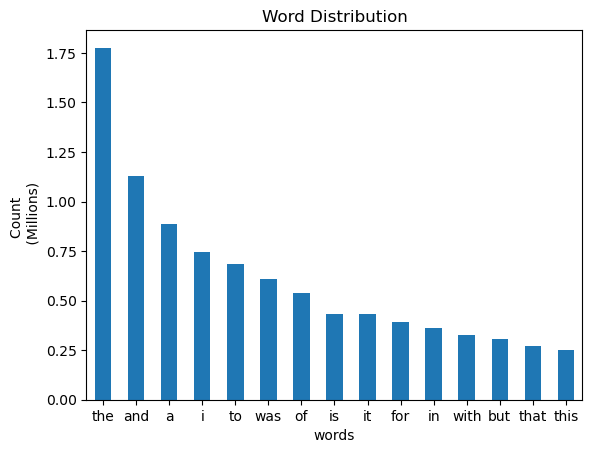

In [14]:
axes = top_15_words_first_ver.plot(kind = "bar",
                                   rot = 0, 
                                   legend = False, 
                                   ylabel = 'Count \n (Millions)',
                                   title = 'Word Distribution',
                                   grid = False
                                  );
plt.show();

In [131]:
all_rev_wo_punc
listToStr = ' '.join(map(str, all_rev_wo_punc))

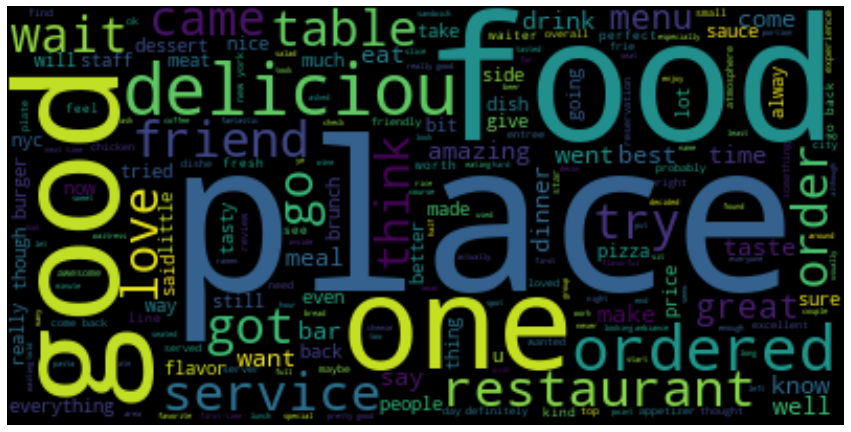

<Figure size 432x288 with 0 Axes>

In [147]:

plt.subplots(figsize = (15,15))
words = listToStr
wordcloud= WordCloud().generate(words)
plt.imshow(wordcloud, interpolation = 'bilinear')

plt.axis('off')
plt.show()
#plt.savefig("word_cloud")

In [15]:
restaurants_df.head()

,user_id,prod_id,rating,date,review,name,target
0,22558,859,5.0,2007-05-28,Looking for some authentic Japanese food at re...,Yakitori Totto,1
1,78837,915,4.0,2009-10-05,Pepe Rosso is where you go when you're in SOHO...,Pepe Rosso To Go,1
2,19590,668,5.0,2013-09-17,I had waited to return a couple other times to...,Eataly NYC,1
3,7175,287,3.0,2013-10-30,This place is always busy - partly because it'...,Heidi’s House,1
4,137409,744,5.0,2014-12-04,Love this place! I am not a regular yelper I d...,Bodhi Tree,0


#### Our goal is to see if a review if fraud or not so the only two key values we need to look at is the target and the review. We create a new dataframe called corpus which dropped unsed columns for analysis.

In [16]:
corpus = restaurants_df.drop(['user_id','prod_id','rating','date','name'],axis = 1)

In [128]:
corpus.head()

,review,target,wo_stopwords
0,Looking for some authentic Japanese food at re...,1,looking authentic japanese food reasonable pri...
1,Pepe Rosso is where you go when you're in SOHO...,1,pepe rosso go soho honkytonk part village near...
2,I had waited to return a couple other times to...,1,i waited return couple times give assessment e...
3,This place is always busy - partly because it'...,1,this place always busy partly tiny but none...
4,Love this place! I am not a regular yelper I d...,0,love place i regular yelper i write review mu...


#### Let's take a closer look at a sample text chosen at random. There are a few items capitalized, a bunch of punctuations as well.

In [40]:
test_doc = corpus.loc[3].review

In [41]:
test_doc

"This place is always busy - partly because it's tiny. But nonethless, call ahead because there will surely be a wait. In any case, they call you when the table is near ready, so you don't need to wait around. Anyway, my bestest and I shared the mac n cheese and some vegetables. The mac n cheese is quite intense and large, so I'm glad we shared because i would've had a heart attack eating the entire dish. The vegetables were also good, though i wish they were baked in the oven and not steamed? We also tried the souffle, and it definitely wasn't worth the $13. I've made a better souffle, and i am no dessert chef. All in all, a quaint and cute little place in the neighborhood, but overpriced and overhyped for what its worth."

In [19]:
sw = stopwords.words('english')

In [21]:
corpus.head()

,review,target
0,Looking for some authentic Japanese food at re...,1
1,Pepe Rosso is where you go when you're in SOHO...,1
2,I had waited to return a couple other times to...,1
3,This place is always busy - partly because it'...,1
4,Love this place! I am not a regular yelper I d...,0


In [23]:
corpus_clean = corpus.copy()

In [44]:
%%time

corpus_clean['review'] = corpus['review'].apply(cf.text_cleaning)

CPU times: user 36.2 s, sys: 861 ms, total: 37 s
Wall time: 38.2 s


#### The data is split again into a train and test set to see how some models will perform with the first text variation.

In [26]:
data = corpus_clean.review
target = corpus_clean.target

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                   target,
                                                   random_state =42,
                                                   stratify = target
                                                  )

## Dummy Model

#### A dummy classifier was created as a baseline to see how the model will perform. With the parameter set as 'most_frequent' we see that this model is highly imbalanced thus has an accuracy of over 89% simply assuming all reviews are true.

In [30]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train,y_train)

DummyClassifier(strategy='most_frequent')

In [31]:
dummy_clf.predict(X_train)
dummy_clf.score(X_train,y_train)

0.8982260658756615

## Initial Model

#### We can vectorize our text with the CountVectorizer to clean the data even further. Running a logistic regression model on it gave an extremely high accuracy score on the training data but the test data was over 10% lower. This shows that this data is overfit.

In [32]:
cv = CountVectorizer(ngram_range=(1,2))
X_vec_train = cv.fit_transform(X_train)
X_vec_test = cv.transform(X_test)

In [33]:
#%%time
#CPU times: user 1h 24min 43s, sys: 14min 8s, total: 1h 38min 51s
#Wall time: 14min 52s

model = LogisticRegression(C=2,max_iter= 100000)
model.fit(X_vec_train, y_train)

LogisticRegression(C=2, max_iter=100000)

In [34]:
predicted_train = model.predict(X_vec_train)

In [37]:
accuracy_value_train = metrics.accuracy_score(y_train, predicted_train)
print(accuracy_value_train)

0.9951514021305858


In [48]:
display(confusion_matrix(predicted_train,y_train))

array([[ 20802,     12],
       [  1028, 192653]])

In [38]:
predicted_test = model.predict(X_vec_test)
accuracy_value_test = metrics.accuracy_score(y_test, predicted_test)

In [39]:
print(accuracy_value_test)

0.8788374662582693


In [47]:
display(confusion_matrix(predicted_test,y_test))

array([[  743,  2129],
       [ 6534, 62093]])

## Second Model

#### Here we create a new column in the corpus that removes stopwords

In [50]:
corpus['wo_stopwords'] = corpus['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

In [148]:
corpus.head()

,review,target,wo_stopwords
0,Looking for some authentic Japanese food at re...,1,looking authentic japanese food reasonable pri...
1,Pepe Rosso is where you go when you're in SOHO...,1,pepe rosso go soho honkytonk part village near...
2,I had waited to return a couple other times to...,1,i waited return couple times give assessment e...
3,This place is always busy - partly because it'...,1,this place always busy partly tiny but none...
4,Love this place! I am not a regular yelper I d...,0,love place i regular yelper i write review mu...


#### We apply the the custom text cleaning function to clean the reviews

In [52]:
corpus['wo_stopwords'] = corpus['wo_stopwords'].apply(text_cleaning)

In [149]:
corpus.head()

,review,target,wo_stopwords
0,Looking for some authentic Japanese food at re...,1,looking authentic japanese food reasonable pri...
1,Pepe Rosso is where you go when you're in SOHO...,1,pepe rosso go soho honkytonk part village near...
2,I had waited to return a couple other times to...,1,i waited return couple times give assessment e...
3,This place is always busy - partly because it'...,1,this place always busy partly tiny but none...
4,Love this place! I am not a regular yelper I d...,0,love place i regular yelper i write review mu...


#### The data is split into a test and train set using the new column. Using the same count vectorizer as before with the new texts, the model did well in the training set but did very poorly in the test set. Increasing decreasing the max_iter did not change the results.

In [54]:
data2 = corpus.wo_stopwords
target2 = corpus.target

In [55]:
X_train, X_test, y_train, y_test = train_test_split(data2,
                                                   target2,
                                                   random_state =42,
                                                   stratify = target
                                                  )

In [56]:
X_vec_train = cv.fit_transform(X_train)
X_vec_test = cv.transform(X_test)

In [57]:
model = LogisticRegression(C=2,max_iter= 100000)
model.fit(X_vec_train, y_train)

LogisticRegression(C=2, max_iter=100000)

In [58]:
predicted_train = model.predict(X_vec_train)

In [115]:
accuracy_value_train = metrics.accuracy_score(y_train, predicted_train)
print(accuracy_value_train)

0.9955103848574559


In [116]:
predicted_test = model.predict(X_vec_test)
accuracy_value_test = metrics.accuracy_score(y_test, predicted_test)
print(accuracy_value_test)

0.887956474915733


In [119]:
model10k = LogisticRegression(C=2,max_iter= 10000)
model10k.fit(X_vec_train, y_train)

LogisticRegression(C=2, max_iter=10000)

In [120]:
p_train = model10k.predict(X_vec_train)

In [121]:
acc_value_train = metrics.accuracy_score(y_train, p_train)
print(acc_value_train)

0.9955103848574559


In [122]:
p_test = model.predict(X_vec_test)
acc_value_test = metrics.accuracy_score(y_test, p_test)
print(acc_value_test)

0.887956474915733


#### This data is heavily imbalanced so we will deploy smote to see if we can adjust the imbalance. With smote the data is now underfit.

In [97]:
#initidate smote
sm = SMOTE()

In [105]:
model2 = LogisticRegression(C=2,max_iter= 10000)

In [106]:
textclassifier =Pipeline([
       ('vect', CountVectorizer()),
       ('smote', SMOTE(random_state=12)),
       ('logr', model2)])

In [107]:
textclassifier.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('smote', SMOTE(random_state=12)),
                ('logr', LogisticRegression(C=2, max_iter=10000))])

In [108]:
y_pred_train = textclassifier.predict(X_train)

In [109]:
accuracy_value_train = roc_auc_score(y_train, y_pred_train)
print(accuracy_value_train)

0.6860640888459659


In [110]:
 y_pred = textclassifier.predict(X_test)

In [111]:
accuracy_value_test = roc_auc_score(y_test, y_pred)
print(accuracy_value_test)

0.5966389712916385


#### Here we create a new dataframe to focus on the top words in both the truth and fraud reviews

In [74]:
corpus_z = corpus[['target','wo_stopwords']]

In [75]:
#isolate the true values
true_BoW = corpus_z[corpus_z['target'] == 1]

In [76]:
#isolate the false values
false_BoW = corpus_z[corpus_z['target'] == 0]

In [77]:
f_LoW = []
for i in false_BoW["wo_stopwords"]:
    f_LoW.append(i)

In [78]:
t_LoW = []
for i in true_BoW["wo_stopwords"]:
    t_LoW.append(i)

In [79]:
t_words = ' '.join(map(str, t_LoW))
f_words = ' '.join(map(str, f_LoW))

In [80]:
t_words[:1000]

'looking authentic japanese food reasonable prices  this place go  we went based recommendations japanes nationals  the food amazing  all skewers really good  ive  different ones menu multiple sittings   everything flavorful  oh  nothing beats winding long day nice cold sappporo reserve    pepe rosso go soho honkytonk part village near nyu want find quick  affordable  no frills  hearty meal  this real neighborhood place  tourist radar  it called pepe rosso to go reason  seating limited quite cramped  if want sit eat there  know getting into  as long accept close company see part pepe s charm  good experience  also remember soho  always classic nyc stoop stair nearby nice nights  sitting stoop penne true nyc experience  especially views empire state building sullivan st  service fairly quick whether dining taking out  i pasta dishes tasty  al dente pasta  good natural sauce  lots real garlic  plus bread   all all  great place delicious  cheap bite eat  i m big fan  no diet coke  skim mi

In [81]:
f_words[:1000]

'love place  i regular yelper i write review much  i fan thai place i eating  years  they good restaurant  great food polite service  restaurant looks clean  i picky food always make happy food i like spicy less oil  if want authentic thai food crowded i recommend  you get table easily great dinner  try crying udon noodle  my favorite menu  if filipino  expect pay     good meal  you mom know cost   something dollars cook adobo  pusit  palabok  kare kare  bokchoy      oh yeah i forget mention individually plated    food mediocre  seem much fusion  the server nerve ask us wanted double orders    hahah watta guy all all  bit overpriced know much something really cost  best grilled cheese sandwiches world  always go back  hands down  favorite park slope haunt  fun bar  festive atmosphere  unfailingly delicious food  i rarely eat fish  yet bogota  i always order it  they blue corn crusted trout occasionally would knock socks off  and i salivate thinking empanadas  seriously  their food also

In [82]:
T_W = [word.strip(string.punctuation) for word in t_words.split(" ")]
F_W = [word.strip(string.punctuation) for word in f_words.split(" ")]

In [83]:
t_w_df = pd.DataFrame(T_W, columns = ['words'])
f_w_df = pd.DataFrame(F_W, columns = ['words'])

In [84]:
t_w_df['index'] = 0
f_w_df['index'] = 0

In [85]:
top_t_w = t_w_df.groupby("words").count().sort_values(by= 'index', ascending = False)
top_f_w = f_w_df.groupby("words").count().sort_values(by= 'index', ascending = False)

In [92]:
#top words for true and false
# top_t_w.to_csv('top_true')
# top_f_w.to_csv('top_false')

#### The top words in the truth is also contained in the fraud reviews.

In [87]:
top_t_w.head(20)

,index
words,
,5342463
i,847935
the,330600
good,179278
it,178415
food,176594
place,165474
s,144817
great,123553


In [88]:
top_f_w.head(20)

,index
words,
,394372
i,61730
the,26112
food,20289
place,16222
good,14069
great,13698
it,12275
s,9719


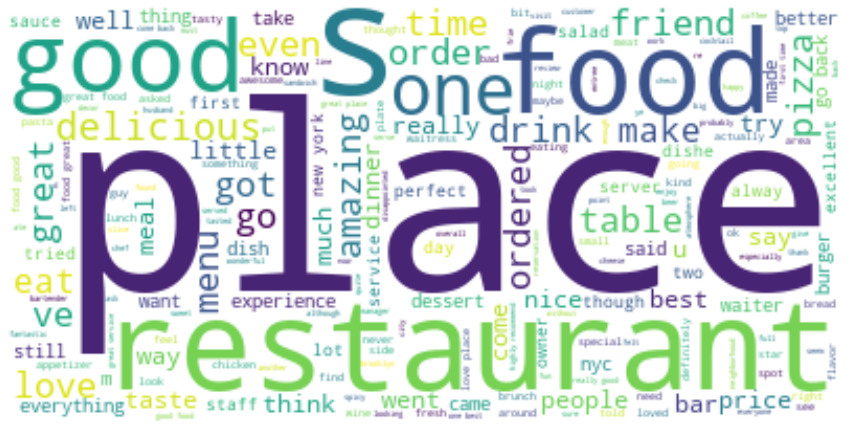

In [142]:
listToStr3 = ' '.join(map(str, F_W))
plt.subplots(figsize = (15,15))
words3 = listToStr3
wordcloud3= WordCloud(background_color ='white').generate(words3)
plt.imshow(wordcloud3, interpolation = 'bilinear')

plt.axis('off')
plt.show()